# Demo notebook for loading/filtering STORM datasets

https://www.nature.com/articles/s41597-020-0381-2

https://doi.org/10.4121/uuid:82c1dc0d-5485-43d8-901a-ce7f26cda35d

https://data.4tu.nl/articles/STORM_IBTrACS_present_climate_synthetic_tropical_cyclone_tracks/12706085?file=24876980

Version 1.0, 8 Dec 2022

In [1]:
import os
import sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker

import cartopy as ctpi
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
print("cartopy Version = {}".format(ctpi.__version__))

import seaborn as sns
sns.set()

cartopy Version = 0.21.0


In [2]:
def addFeatures(ax):
    """
    """
    kwargs = {"scale": '50m', "facecolor": "none",  "edgecolor": "k", "linewidth": 1.5} 
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', name='coastline', **kwargs))
    kwargs = {"scale": '110m', "facecolor": "none",  "edgecolor": "k", "linewidth": .5} 
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', name='lakes', **kwargs))
    ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', **kwargs))
    ax.add_feature(cfeature.NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', **kwargs))

def discrete_cmap(N, base_cmap=None):
    """
    Create an N-bin discrete colormap from the specified input map
    """

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


def TrackPlot(df,extent=None,axx=None,fname=None,circ=None):
    """
    """
    #addcolorbar=False
    if axx is None:
        fig, axx = plt.subplots(nrows=1, ncols=1, dpi=72,
                           figsize=(12, 12), 
                           subplot_kw={'projection': crs})
    #    addcolorbar=True
    addcolorbar=True
    
    IDX=np.unique(df.index).astype(int)
    
    for i,idx in enumerate(IDX): # [0:10]:
        x=df.loc[df.index==idx].Longitude
        y=df.loc[df.index==idx].Latitude
        c=df.loc[df.index==idx].Min_pres
        axx.plot(x, y, linewidth=.1, transform=crs, color='k')
        axx.plot(x.iloc[0], y.iloc[0], marker='*', transform=crs, color='g')
        axx.plot(x.iloc[-1], y.iloc[-1], marker='*', transform=crs, color='r')
        cm=axx.scatter(x=x, y=y, c=c, cmap=cmap, transform=crs, norm=norm, s=12)
        
    if extent is not None: 
        axx.set_extent(extent)
        
    addFeatures(axx)
    gl = axx.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.xlabel_style = {'size': 12, 'color': 'k'}
    gl.ylabel_style = {'size': 12, 'color': 'k'}
    gl.left_labels = True
    gl.right_labels = False
    gl.bottom_labels = True
    gl.xlocator = mticker.FixedLocator(np.arange(-120, 0, 5))
    gl.ylocator = mticker.FixedLocator(np.arange(   0, 70, 5))
    
    if circ is not None:
        axx.plot(circ['cirx'],circ['ciry'],transform=crs,linewidth=3, color='k')
        
    
    if addcolorbar:
        cb1 = plt.colorbar(cm, ax=axx, orientation='vertical', pad=0.02, aspect=15, shrink=0.15)
        cb1.ax.set_ylabel('[mb]', size=12)
        cb1.ax.tick_params(labelsize='large')
    
    if fname is not None:
        fig.savefig(fname)
    
def fullTrackPlot(dfnc,extentnc,nc_circ,dftx,extenttx,tx_circ,fname=None):
    """
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, dpi=144,
                           figsize=(18, 36), # sharey=True,
                           subplot_kw={'projection': crs})

    TrackPlot(dftx,extent=extenttx,axx=ax[0],circ=tx_circ)
    TrackPlot(dfnc,extent=extentnc,axx=ax[1],circ=nc_circ)

    # cb1 = fig.colorbar(cm, ax=ax, orientation='vertical', pad=0.02, shrink=0.19, aspect=15)
    # cb1.ax.set_ylabel('[mb]', size=12)
    # cb1.ax.tick_params(labelsize='large')

    if fname is not None:
        fig.savefig(fname)
        
def LoadSTORMFile(url):
    """
    """
    df=pd.read_csv(url, names=cols)

    # generate an "absolute storm number (abssn)" to uniquely identify each storm 
    # in the dataset, then set that to be the dataframe index
    df['abssn']=np.cumsum(1*(df.Time_step==0))
    df.set_index('abssn',inplace=True)

    idx_all=np.unique(df.index).astype(int)

    # add a Day, Hour columns
    day=np.floor(df['Time_step']*3/24+1)
    df.insert(2, 'Day', day)
    hour=24*(df['Time_step']*3/24+1-df['Day'])
    df.insert(3, 'Hour', hour)

    df['Longitude']=df['Longitude']-360
    return df

In [3]:
basin='NA'
ensnum=0
climate='current' 
baseurl='http://tds3.renci.org:8080/thredds/fileServer/cheer/STORM_Bloemendaal_data'
url=f'{baseurl}/{climate}/STORM_DATA_IBTRACS_{basin}_1000_YEARS_{ensnum}.txt'
#url=f'http://tds3.renci.org:8080/thredds/fileServer/cheer/STORM_Bloemendaal_data/future/HADGEM/STORM_DATA_HadGEM3-GC31-HM_{basin}_1000_YEARS_{ensnum}_IBTRACSDELTA.txt'
print(url)

# define some plotting vars
N=24
cmap=discrete_cmap(N, 'jet_r')
norm = mpl.colors.Normalize(vmin=900, vmax=1020)
crs = ccrs.PlateCarree() # central_longitude=central_lon)


# define dicts for filtering circles for case study areas:
a=np.arange(0,370,10)*np.pi/180
rad=3
lo=-76.5
la=34.75
nc_circ={'lo': lo,
         'la': la, 
         'rad': rad,
         'cirx': rad*np.cos(a)+lo,
         'ciry': rad*np.sin(a)+la}

rad=3
lo=-94
la=29.5
tx_circ={'lo': lo,
         'la':  la,
         'rad': rad,
         'cirx': rad*np.cos(a)+lo,
         'ciry': rad*np.sin(a)+la}

# column def of STORM files
cols=[
    'Year',       # Starts at 0
    'Month', 
    'TC_number',  # For every year; starts at 0.
    'Time_step',  # 3-hr, For every TC; starts at 0.
    'Basin_ID',   # 0=EP, 1=NA, 2=NI, 3=SI, 4=SP, 5=WP
    'Latitude',   # Deg, Position of the eye.
    'Longitude',  # Deg, Position of the eye. Ranges from 0-360°, with prime meridian at Greenwich.
    'Min_pres',   # hPa
    'MaxWindSpd', # m/s
    'RMW',        # km
    'Category',   #
    'Landfall',   # 0= no landfall, 1= landfall
    'Dist2land'   # km
    ]


http://tds3.renci.org:8080/thredds/fileServer/cheer/STORM_Bloemendaal_data/current/STORM_DATA_IBTRACS_NA_1000_YEARS_0.txt


In [4]:
# Load the STORM dataset
df=LoadSTORMFile(url)

# Compute a "distance" to the target areas, used to screen storm population
df['dist2nc']=np.sqrt(np.square(df['Longitude']-nc_circ['lo']) + np.square(df['Latitude']-nc_circ['la']))
df['dist2tx']=np.sqrt(np.square(df['Longitude']-tx_circ['lo']) + np.square(df['Latitude']-tx_circ['la']))

display(df.head(10))

,Year,Month,Day,Hour,TC_number,Time_step,Basin_ID,Latitude,Longitude,Min_pres,MaxWindSpd,RMW,Category,Landfall,Dist2land,dist2nc,dist2tx
abssn,,,,,,,,,,,,,,,,,
1,0.0,10.0,1.0,0.0,0.0,0.0,1.0,8.9,-45.2,993.946699,20.371998,46.299999,0.0,0.0,851.946656,40.594489,52.969803
1,0.0,10.0,1.0,3.0,0.0,1.0,1.0,9.0,-45.7,992.800000,21.200000,45.905957,0.0,0.0,815.967429,40.146015,52.470373
1,0.0,10.0,1.0,6.0,0.0,2.0,1.0,9.1,-46.4,992.100000,21.700000,45.511914,0.0,0.0,766.103506,39.546586,51.787257
1,0.0,10.0,1.0,9.0,0.0,3.0,1.0,9.2,-47.3,993.000000,21.100000,45.117872,0.0,0.0,705.759651,38.800032,50.921312
1,0.0,10.0,1.0,12.0,0.0,4.0,1.0,9.3,-48.3,993.100000,20.900000,44.723829,0.0,0.0,647.548285,37.986083,49.965288
1,0.0,10.0,1.0,15.0,0.0,5.0,1.0,9.5,-49.3,992.700000,21.200000,44.329787,0.0,0.0,605.239404,37.113374,48.970297
1,0.0,10.0,1.0,18.0,0.0,6.0,1.0,9.7,-50.4,993.300000,20.800000,43.935744,0.0,0.0,555.779467,36.176132,47.885280
1,0.0,10.0,1.0,21.0,0.0,7.0,1.0,9.9,-51.5,993.900000,20.300000,43.541702,0.0,0.0,526.198018,35.249433,46.801816
1,0.0,10.0,2.0,0.0,0.0,8.0,1.0,10.1,-52.6,994.000000,20.200000,43.147659,0.0,0.0,499.451982,34.334130,45.720017


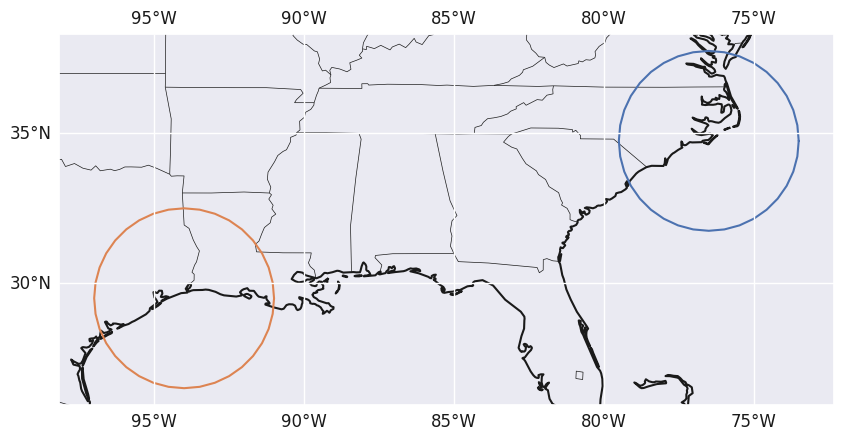

In [5]:
# plot the screening circles
fig, ax = plt.subplots(nrows=1, ncols=1, 
                       figsize=(10, 10), 
                       subplot_kw={'projection': crs})
ax.plot(nc_circ['cirx'],nc_circ['ciry'],transform=crs)
ax.plot(tx_circ['cirx'],tx_circ['ciry'],transform=crs)
#ax.plot(df['Longitude'].iloc[0],df['Latitude'].iloc[0],transform=crs,marker='*')

addFeatures(ax)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlabel_style = {'size': 12, 'color': 'k'}
gl.ylabel_style = {'size': 12, 'color': 'k'}
gl.left_labels = True
gl.right_labels = False
gl.bottom_labels = True
gl.xlocator = mticker.FixedLocator(np.arange(-100, -40, 5))
gl.ylocator = mticker.FixedLocator(np.arange(   0,  50, 5))

In [6]:
# Find the storm index numbers (anssn) that pass thru the screening circles
# This gets the parts of tracks that enter the circles.  The complete track will be extracted below
df_nc=df.loc[(df['dist2nc'] <=nc_circ['rad'])] #  & (df['Min_pres'] <= 980)]
df_tx=df.loc[(df['dist2tx'] <=tx_circ['rad'])] #  & (df['Min_pres'] <= 980)]
idx_nc=np.unique(df_nc.index).astype(int)
idx_tx=np.unique(df_tx.index).astype(int)
print(f'Initial number of NC events = {len(idx_nc)}')
print(f'Initial number of TX events = {len(idx_tx)}')

Initial number of NC events = 588
Initial number of TX events = 493


In [ ]:
# Screen out storms shorter than MinDays

MinDays=4
temp_list=list()
for idx in idx_nc: 
    df_temp=df.loc[df.index==idx].copy()    
    d=df_temp.iloc[:,2].values[-1]
    if d > MinDays: 
        temp_list.append(df_temp)
df_nc=pd.concat(temp_list)
idx_nc=np.unique(df_nc.index).astype(int)  # update index
          
temp_list=list()
for idx in idx_tx:
    df_temp=df.loc[df.index==idx].copy()
    d=df_temp.iloc[:,2].values[-1]
    if d > MinDays: 
        temp_list.append(df_temp)    
df_tx=pd.concat(temp_list)
idx_tx=np.unique(df_tx.index).astype(int)

extent=[-100, 0, 0, 60]
fullTrackPlot(df_nc,extent,nc_circ,df_tx,extent,tx_circ,fname='STORM_NA_0_NC_TX_PRESENT_1.png')

print(f'Number of NC events = {len(idx_nc)}')
print(f'Number of TX events = {len(idx_tx)}')

# display(df_nc.head())
# display(df_tx.head())

Number of NC events = 240
Number of TX events = 69


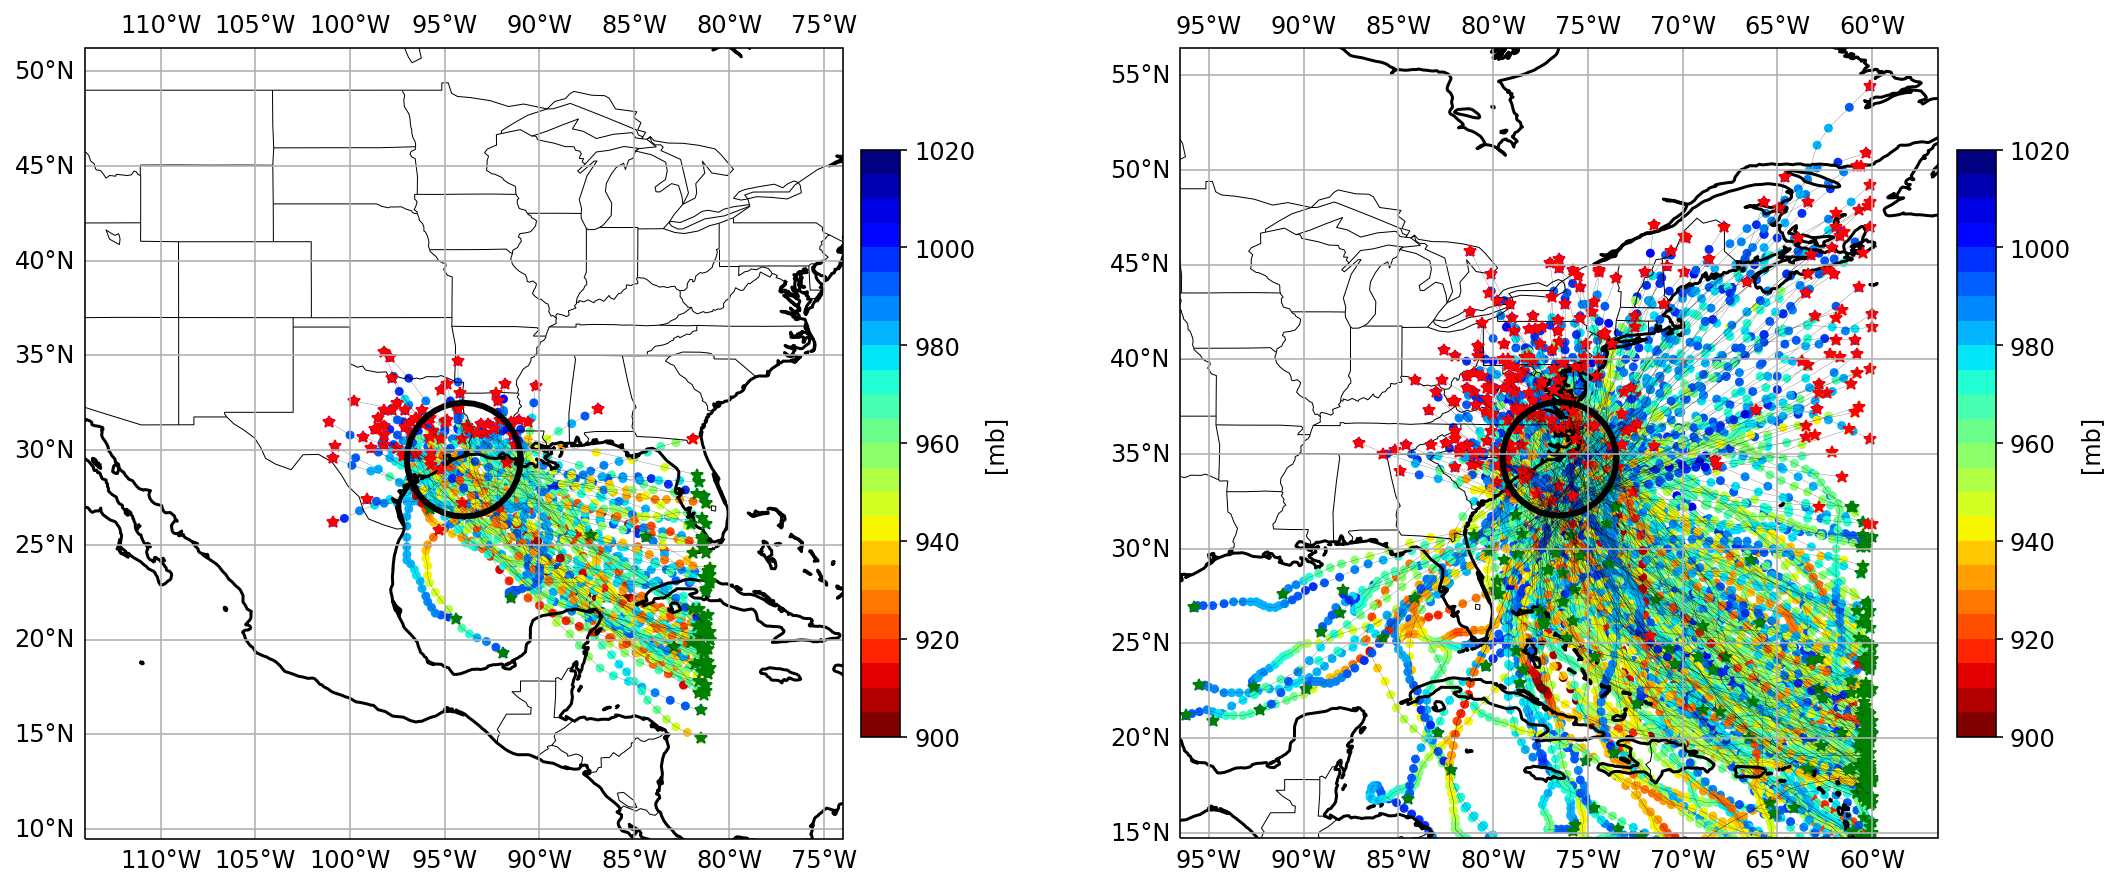

In [17]:
#  Screen out parts of storm tracks significantly far from the study areas
#  and eliminate storms that start within the screening circle.  [Need to think about
# this, but probably too close to coast to allow for complete spinup.]
MaxLon_At_Start_Of_Track_NC=-60
temp_list=list()
for i,idx in enumerate(idx_nc): 
    df_temp=df_nc.loc[df_nc.index==idx].copy()    
    
    while df_temp['Longitude'].iloc[0] > MaxLon_At_Start_Of_Track_NC:
        df_temp = df_temp.iloc[1: , :]
    while df_temp['Longitude'].iloc[-1] > MaxLon_At_Start_Of_Track_NC:
        df_temp = df_temp.iloc[:-2 , :]
    if df_temp.dist2nc.iloc[0] < nc_circ['rad']:
        df_temp = pd.DataFrame()
    temp_list.append(df_temp)
    
df_nc=pd.concat(temp_list)
idx_nc=np.unique(df_nc.index).astype(int)  # update index

MinLon_At_Start_Of_Track_TX=-81
temp_list=list()
for i,idx in enumerate(idx_tx): 
    df_temp=df_tx.loc[df_tx.index==idx].copy()    
    
    while df_temp['Longitude'].iloc[0] > MinLon_At_Start_Of_Track_TX:
        df_temp = df_temp.iloc[1: , :]
    while df_temp['Longitude'].iloc[-1] > MinLon_At_Start_Of_Track_TX:
        df_temp = df_temp.iloc[:-2 , :]
    if df_temp.dist2tx.iloc[0] < tx_circ['rad']:
        df_temp = pd.DataFrame()
        
    temp_list.append(df_temp)
    
df_tx=pd.concat(temp_list)
idx_tx=np.unique(df_tx.index).astype(int)

print(f'Number of NC events = {len(idx_nc)}')
print(f'Number of TX events = {len(idx_tx)}')

# make plot of result
dlo, dla = 20, 20
extnc=[nc_circ['lo']-dlo, nc_circ['lo']+dlo, nc_circ['la']-dla, nc_circ['la']+dla]
exttx=[tx_circ['lo']-dlo, tx_circ['lo']+dlo, tx_circ['la']-dla, tx_circ['la']+dla]
fullTrackPlot(df_nc,extnc,nc_circ,df_tx,exttx,tx_circ,fname='STORM_NA_0_NC_TX_PRESENT_2.png')


In [22]:
# Flush tracks to csv files
# Loop over abssns in subset and export complete track for each
if not os.path.exists('CHEER_Tracks'):
    os.mkdir('CHEER_Tracks')
    
for idx in idx_nc: # [0:10]:
    fname=f'CHEER_Tracks/NC_Present_{ensnum}_{idx:05d}.csv'
    df_temp=df_nc.loc[df_nc.index==idx]
    df_temp.to_csv(fname)

for idx in idx_tx: # [0:10]:
    fname=f'CHEER_Tracks/TX_Present_{ensnum}_{idx:05d}.csv'
    df_temp=df_tx.loc[df_tx.index==idx]
    df_temp.to_csv(fname)
    
# also save as pkl files for subsequent loading/analysis
df_nc.to_pickle(f'NC_Present_{ensnum}.pkl')
df_tx.to_pickle(f'TX_Present_{ensnum}.pkl')

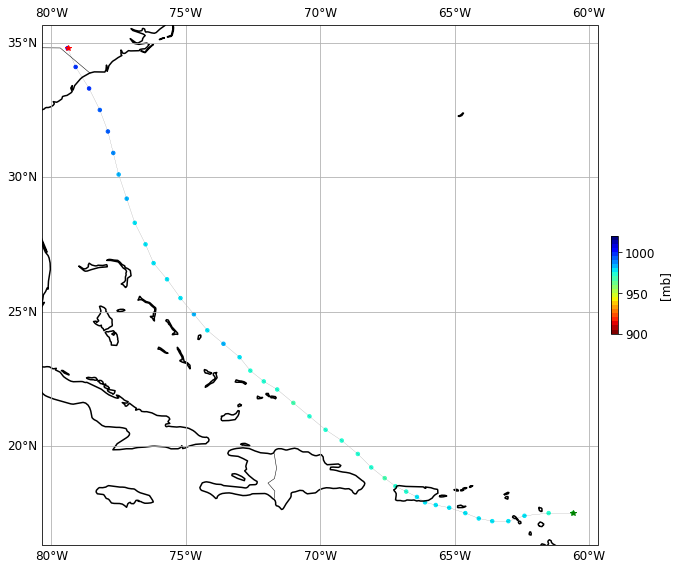

In [24]:
# plot one track
idx=idx_nc[0]
df_sub=df_nc.loc[df_nc.index==idx]
TrackPlot(df_sub,fname=f'STORM_NA_NC_{climate}_{ensnum}_exampleTrack.png')

# Figure 4: Synthetic hurricanes from the STORM dataset. 

In [ ]:
# Interesting plot of all tracks and case study tracks

# basin-scale
extent = [ -90, -15, 5, 60] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
crs = ccrs.LambertConformal(central_longitude=central_lon, central_latitude=central_lat)

fig, ax = plt.subplots(nrows=1, ncols=1, 
                       figsize=(16, 16), 
                       constrained_layout=True,
                       subplot_kw={'projection': crs})

for idx in idx_all:
    x=df.loc[df.index==idx].Longitude
    y=df.loc[df.index==idx].Latitude
    c=df.loc[df.index==idx].Min_pres
    ax.plot(x, y, linewidth=.1, transform=ccrs.PlateCarree(), color='k')
    #cm=ax[0].scatter(x=x, y=y, c=c, cmap=cmap, transform=crs, norm=norm, s=12)
    
for i,idx in enumerate(idx_tx): 
    x=df_tx.loc[df_tx.index==idx].Longitude
    y=df_tx.loc[df_tx.index==idx].Latitude
    c=df_tx.loc[df_tx.index==idx].Min_pres
    ax.plot(x, y, linewidth=.5,  transform=ccrs.PlateCarree(), color='r')
    
for k,idx in enumerate(idx_nc): 
    x=df_nc.loc[df_nc.index==idx].Longitude
    y=df_nc.loc[df_nc.index==idx].Latitude
    c=df_nc.loc[df_nc.index==idx].Min_pres
    ax.plot(x, y, linewidth=.5,  transform=ccrs.PlateCarree(), color='b')
    
plt.grid(True)
cb1 = fig.colorbar(cm, ax=ax, orientation='vertical', shrink=0.65, pad=0.025)
cb1.ax.set_ylabel('[mb]', size=16)
cb1.ax.tick_params(labelsize='large')

ax.set_extent(extent)
addFeatures(ax)
#set_gridLines(ax,False,True,True,False)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlabel_style = {'size': 15, 'color': 'k'}
gl.ylabel_style = {'size': 15, 'color': 'k'}
gl.right_labels = False
gl.bottom_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-100,0,5))
gl.ylocator = mticker.FixedLocator(np.arange(0,80,5))

plt.box(True)

fig.savefig(f'STORM_NA_{climate}_{ensnum}.png')